In [1]:
%%local
%matplotlib inline

In [2]:
import json
import pyspark.sql.functions as F
from pyspark.sql import Row

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
297,application_1657650108716_0299,pyspark,idle,Link,Link,shirleywu,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
ep_connect_rdd = sc.sequenceFile('s3://mist-secorapp-production/ep-connect-status/ep-connect-status-production/dt=2022-08-16/hr=07/')\
            .map(lambda r: json.loads(r[1]))


connect_df = ep_connect_rdd.filter(lambda r: 'Terminator' in r and 'LBAddr' in r  and r['Status'] in [1, 2])\
 .map(lambda r: Row(terminator=r['Terminator'], 
                   lb_addr=r['LBAddr'], 
                   timestamp=r['Timestamp'][0:19], 
                   ap=r['ID'], 
                   org_id=r.get('OrgID'), 
                   site_id=r.get('SiteID'), 
                   status=r['Status']))\
 .toDF()

connect_df.repartition(5).write.format('parquet').mode('overwrite').save('s3://mist-data-science-dev/shirley/ep-connect-status/dt=2022-08-15/hr={:02d}'.format(h))
print("done with hour hr={:02d}".format(h))

# 	DISCONNECTED      StatusEventType = 2 /* AP Disconnected from websocket*/

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:

from datetime import datetime, timedelta
def date_to_5_min(ts_str):
    dt = datetime.fromisoformat(ts_str)
    ss = dt.second
    new_sec = (ss // 5) * 5
    dt = dt.replace(second=new_sec, microsecond=0)
    return dt.strftime("%Y-%m-%d %H:%M:%S")


def date_to_10_min(ts_str):
    dt = datetime.fromisoformat(ts_str)
    ss = dt.second
    new_sec = (ss // 10) * 10
    dt = dt.replace(second=new_sec, microsecond=0)
    return dt.strftime("%Y-%m-%d %H:%M:%S")


def date_to_1_hr(ts_str):
    dt = datetime.fromisoformat(ts_str)
    dt = dt.replace(minute=0, second=0, microsecond=0)
    return dt.strftime("%Y-%m-%d %H:%M:%S")


def date_to_epoch(ts_str):
    dt = datetime.fromisoformat(ts_str)
    return int(dt.timestamp())


from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType, LongType

convertUDF = F.udf(lambda z: date_to_10_min(z), StringType())
convert_1hour_UDF = F.udf(lambda z: date_to_1_hr(z), StringType())
convert_epochUDF = F.udf(lambda z: date_to_epoch(z), LongType())


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
def reconnect_delta(list_of_events):
    '''
    For a list of events, sorted them in reverse order, start from the latest connect event, find the previous 
    '''
    sorted_events = list(list_of_events)
    
    sorted_events.sort(key=lambda r: r['ts_epoch'], reverse=True)
    
    start = -1
    for e in sorted_events:
        # 1 ===> CONNECT
        # 2 ===> DISCONNECT
        if e['status'] == 1:
            if start < 0:
                start = e['ts_epoch']
        elif e['status'] == 2:
            if start > 0:
                ts_delta = start - e['ts_epoch']
                start = -1
                yield ts_delta
    yield -1

    
    
connect_time_delta_rdd = formated_df.rdd.groupBy(lambda r: (r['ap'], r['ts_str_1hour'])).flatMapValues(lambda r: reconnect_delta(r)).filter(lambda r: r[1] > 0)

# connect_time_delta_rdd.take(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(date_str, pdf, delta_series):

    plt.grid()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    fig.suptitle("Aug {}th Connect/Disconnect Time Delta Analysis".format(date_str))
       
    N, bins, patches = ax1.hist(delta_series, edgecolor='white', linewidth=1, bins=[0, 90, 360, 600, 720])
    for i in range(0, 1):
        patches[i].set_facecolor('g')
    for i in range(1, 2):    
        patches[i].set_facecolor('b')
    for i in range(2, 3):
        patches[i].set_facecolor('orange')
    for i in range(3, len(patches)):
        patches[i].set_facecolor('red')
    
    ax1.set_title('Time Delta Histogram(seconds)')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Time Delta(seconds)')

    ax2.set_title('Hourly Event Count')
    ax2.set_ylabel('Event Count')
    pdf['event_count'].plot(x='ts_str_1hour', kind='bar', ax=ax2)

    ax3.set_title('Hourly Time Delta Distribution(seconds)')
    ax3.set_ylabel('Time Delta(seconds)')
    ax3.plot(pdf['avg_connect_delta'], label='avg', color='green')
    ax3.plot(pdf['median'], label='median', color='blue')
    ax3.legend(loc="upper right")
    
    plt.xticks(rotation = 90) 
    plt.show()

def reconnect_delta(list_of_events):
    '''
    For a list of events, sorted them in reverse order, start from the latest connect event, find the previous 
    '''
    sorted_events = list(list_of_events)
    
    sorted_events.sort(key=lambda r: r['ts_epoch'], reverse=True)
    
    start = -1
    for e in sorted_events:
        # 1 ===> CONNECT
        # 2 ===> DISCONNECT
        if e['status'] == 1:
            if start < 0:
                start = e['ts_epoch']
        elif e['status'] == 2:
            if start > 0:
                ts_delta = start - e['ts_epoch']
                start = -1
                yield ts_delta
    yield -1

    
def agg_and_plot(dt_number):
    connet_df = spark.read.parquet('s3://mist-data-science-dev/shirley/ep-connect-status/dt=2022-08-{:02d}/hr=*/'.format(dt_number))
    formated_df = connet_df.filter( (F.col('ap').isNotNull()) & (F.length(F.col('ap')) == 17)).\
                        withColumn('ts_str_10min', convertUDF('timestamp')).\
                        withColumn('ts_epoch', convert_epochUDF('timestamp')).\
                        withColumn('ts_str_1hour', convert_1hour_UDF('timestamp'))
    
    hourly_event_count_pdf = formated_df.groupBy('ts_str_1hour').agg(F.count(F.col('ts_str_1hour')).alias('event_count')).toPandas().set_index('ts_str_1hour')
    
    connect_time_delta_rdd = formated_df.rdd.groupBy(lambda r: (r['ap'], r['ts_str_1hour'])).flatMapValues(lambda r: reconnect_delta(r)).filter(lambda r: r[1] > 0).persist()
    
    
    time_delta_df = connect_time_delta_rdd.map(lambda r: Row(ap=r[0][0], ts_str_1hour=r[0][1], ts_delta=r[1])).toDF().persist()
    delta_pdf = time_delta_df.select('ts_delta').toPandas()
    time_delta_bucket_df = time_delta_df.groupBy(F.col('ts_str_1hour')).agg(F.avg(F.col('ts_delta')).cast(IntegerType()).alias('avg_connect_delta'),
                                                                        F.percentile_approx("ts_delta", 0.5, F.lit(1000000)).alias("median"),
                                                                        F.percentile_approx("ts_delta", 0.95, F.lit(1000000)).alias("95_percentile")).persist()
    
    time_delta_bucket_pdf = time_delta_bucket_df.orderBy('ts_str_1hour').toPandas().set_index('ts_str_1hour')
    hourly_pdf = pd.merge(time_delta_bucket_pdf, hourly_event_count_pdf, left_index=True, right_index=True)

    # events with duration > 90s
    ad_connect_time_delta_rdd = connect_time_delta_rdd.filter(lambda r: r[1] > 90)
    ad_hourly_event_count_pdf = ad_connect_time_delta_rdd.map(lambda r: Row(ts_str_1hour=r[0][1], count=1)).toDF().groupBy('ts_str_1hour').agg(F.sum(F.col('count')).alias('event_count')).toPandas().set_index('ts_str_1hour')
    ad_time_delta_df = ad_connect_time_delta_rdd.map(lambda r: Row(ap=r[0][0], ts_str_1hour=r[0][1], ts_delta=r[1])).toDF().persist()
    ad_delta_pdf = ad_time_delta_df.select('ts_delta').toPandas()
    ad_time_delta_bucket_df = ad_time_delta_df.groupBy(F.col('ts_str_1hour')).agg(F.avg(F.col('ts_delta')).cast(IntegerType()).alias('avg_connect_delta'),
                                                                                  F.percentile_approx("ts_delta", 0.5, F.lit(1000000)).alias("median"),
                                                                                  F.percentile_approx("ts_delta", 0.95, F.lit(1000000)).alias("95_percentile")).persist()
    ad_time_delta_bucket_pdf = ad_time_delta_bucket_df.orderBy('ts_str_1hour').toPandas().set_index('ts_str_1hour')
    ad_hourly_pdf = pd.merge(ad_time_delta_bucket_pdf, ad_hourly_event_count_pdf, left_index=True, right_index=True)
    
    return hourly_pdf, delta_pdf, ad_hourly_pdf, ad_delta_pdf
    

    
def date_to_1_min(ts_str):
    dt = datetime.fromisoformat(ts_str)
    dt = dt.replace(second=0, microsecond=0)
    return dt.strftime("%Y-%m-%d %H:%M:%S")

convert_1min_UDF = F.udf(lambda z: date_to_1_min(z), StringType())



def reconnect_delta_2(list_of_events):
    '''
    For a list of events, sorted them in reverse order, start from the latest connect event, find the previous 
    '''
    sorted_events = list(list_of_events)
    
    sorted_events.sort(key=lambda r: r['ts_epoch'], reverse=False)
    
    start_e = None
    start_e = None
    for e in sorted_events:
        # 1 ===> CONNECT
        # 2 ===> DISCONNECT
        
        if e['status'] == 2:
            
            if start_e is None:
                start_e = e
        elif e['status'] == 1:
            if start_e is not None:
                ts_delta = e['ts_epoch'] - start_e['ts_epoch']
                yield ts_delta, start_e['ts_str_1min'], e['ts_str_1min']
                start_e = None

    yield -1, 0, 0
    

def agg_problem_hour(dt_number, hr_number):
    connet_df = spark.read.parquet('s3://mist-data-science-dev/shirley/ep-connect-status/dt=2022-08-{:02d}/hr={:02d}/'.format(dt_number, hr_number))
    formated_df = connet_df.filter( (F.col('ap').isNotNull()) & (F.length(F.col('ap')) == 17)).\
                            withColumn('ts_str_1min', convert_1min_UDF('timestamp')).\
                            withColumn('ts_epoch', convert_epochUDF('timestamp'))

    event_count_pdf = formated_df.groupBy('ts_str_1min').agg(F.count(F.col('ts_str_1min')).alias('event_count')).toPandas().set_index('ts_str_1min')

    connect_time_delta_rdd = formated_df.rdd.groupBy(lambda r: r['ap']).flatMapValues(lambda r: reconnect_delta_2(r)).filter(lambda r: r[1][0] > 0)

    time_delta_df = connect_time_delta_rdd.map(lambda r: Row(ap=r[0], ts_delta=r[1][0], ts_str_1min=r[1][1], ts_str_1min_end=r[1][2])).toDF().persist()
    delta_pdf = time_delta_df.select('ts_delta').toPandas()
    time_delta_bucket_df = time_delta_df.groupBy(F.col('ts_str_1min')).agg(F.avg(F.col('ts_delta')).cast(IntegerType()).alias('avg_connect_delta'),
                                                                            F.percentile_approx("ts_delta", 0.5, F.lit(1000000)).alias("median"),
                                                                            F.percentile_approx("ts_delta", 0.95, F.lit(1000000)).alias("95_percentile")).persist()

    time_delta_bucket_pdf = time_delta_bucket_df.orderBy('ts_str_1min').toPandas().set_index('ts_str_1min')

    minute_pdf = pd.merge(time_delta_bucket_pdf, event_count_pdf, left_index=True, right_index=True)

    # exclude detal > 90s
    ad_connect_time_delta_rdd = connect_time_delta_rdd.filter(lambda r: r[1][0] > 90)

    ad_event_count_pdf = ad_connect_time_delta_rdd.map(lambda r: Row(ts_str_1min=r[1][1], count=1)).toDF().groupBy('ts_str_1min').agg(F.sum(F.col('count')).alias('event_count')).toPandas().set_index('ts_str_1min')
    ad_time_delta_df = ad_connect_time_delta_rdd.map(lambda r: Row(ap=r[0], ts_delta=r[1][0], ts_str_1min=r[1][1], ts_str_1min_end=r[1][2])).toDF().persist()

    ad_delta_pdf = ad_time_delta_df.select('ts_delta').toPandas()

    ad_time_delta_bucket_df = ad_time_delta_df.groupBy(F.col('ts_str_1min')).agg(F.avg(F.col('ts_delta')).cast(IntegerType()).alias('avg_connect_delta'),
                                                                                 F.percentile_approx("ts_delta", 0.5, F.lit(1000000)).alias("median"),
                                                                                 F.percentile_approx("ts_delta", 0.95, F.lit(1000000)).alias("95_percentile")).persist()

    ad_time_delta_bucket_pdf = ad_time_delta_bucket_df.orderBy('ts_str_1min').toPandas().set_index('ts_str_1min')

    ad_minute_pdf = pd.merge(ad_time_delta_bucket_pdf, ad_event_count_pdf, left_index=True, right_index=True)
    delta_pdf

    return minute_pdf, delta_pdf, ad_minute_pdf, ad_delta_pdf

def plot_hourly(date_number, hr_number, pdf, delta_series):

    plt.grid()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    fig.suptitle("Aug {:02d} Hour {:02d} Connect/Disconnect Time Delta Analysis".format(date_number, hr_number))
       
    N, bins, patches = ax1.hist(delta_series, edgecolor='white', linewidth=1, bins=[0, 90, 360, 600, 720])
    for i in range(0, 1):
        patches[i].set_facecolor('g')
    for i in range(1, 2):    
        patches[i].set_facecolor('b')
    for i in range(2, 3):
        patches[i].set_facecolor('orange')    
    for i in range(3, len(patches)):
        patches[i].set_facecolor('r')
    
    ax1.set_title('Time Delta Histogram(seconds)')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Time Delta(seconds)')

    ax2.set_title('By Minute Event Count')
    ax2.set_ylabel('Event Count')
    pdf['event_count'].plot(x='ts_str_1min', kind='bar', ax=ax2)

    ax3.set_title('By Minute Time Delta Distribution(seconds)')
    ax3.set_ylabel('Time Delta(seconds)')
    ax3.plot(pdf['avg_connect_delta'], label='avg', color='green')
    ax3.plot(pdf['median'], label='median', color='blue')
    ax3.plot(pdf['95_percentile'], label='95_percentile', color='red')
    ax3.legend(loc="upper right")
    
    plt.xticks(rotation = 90) 
    plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

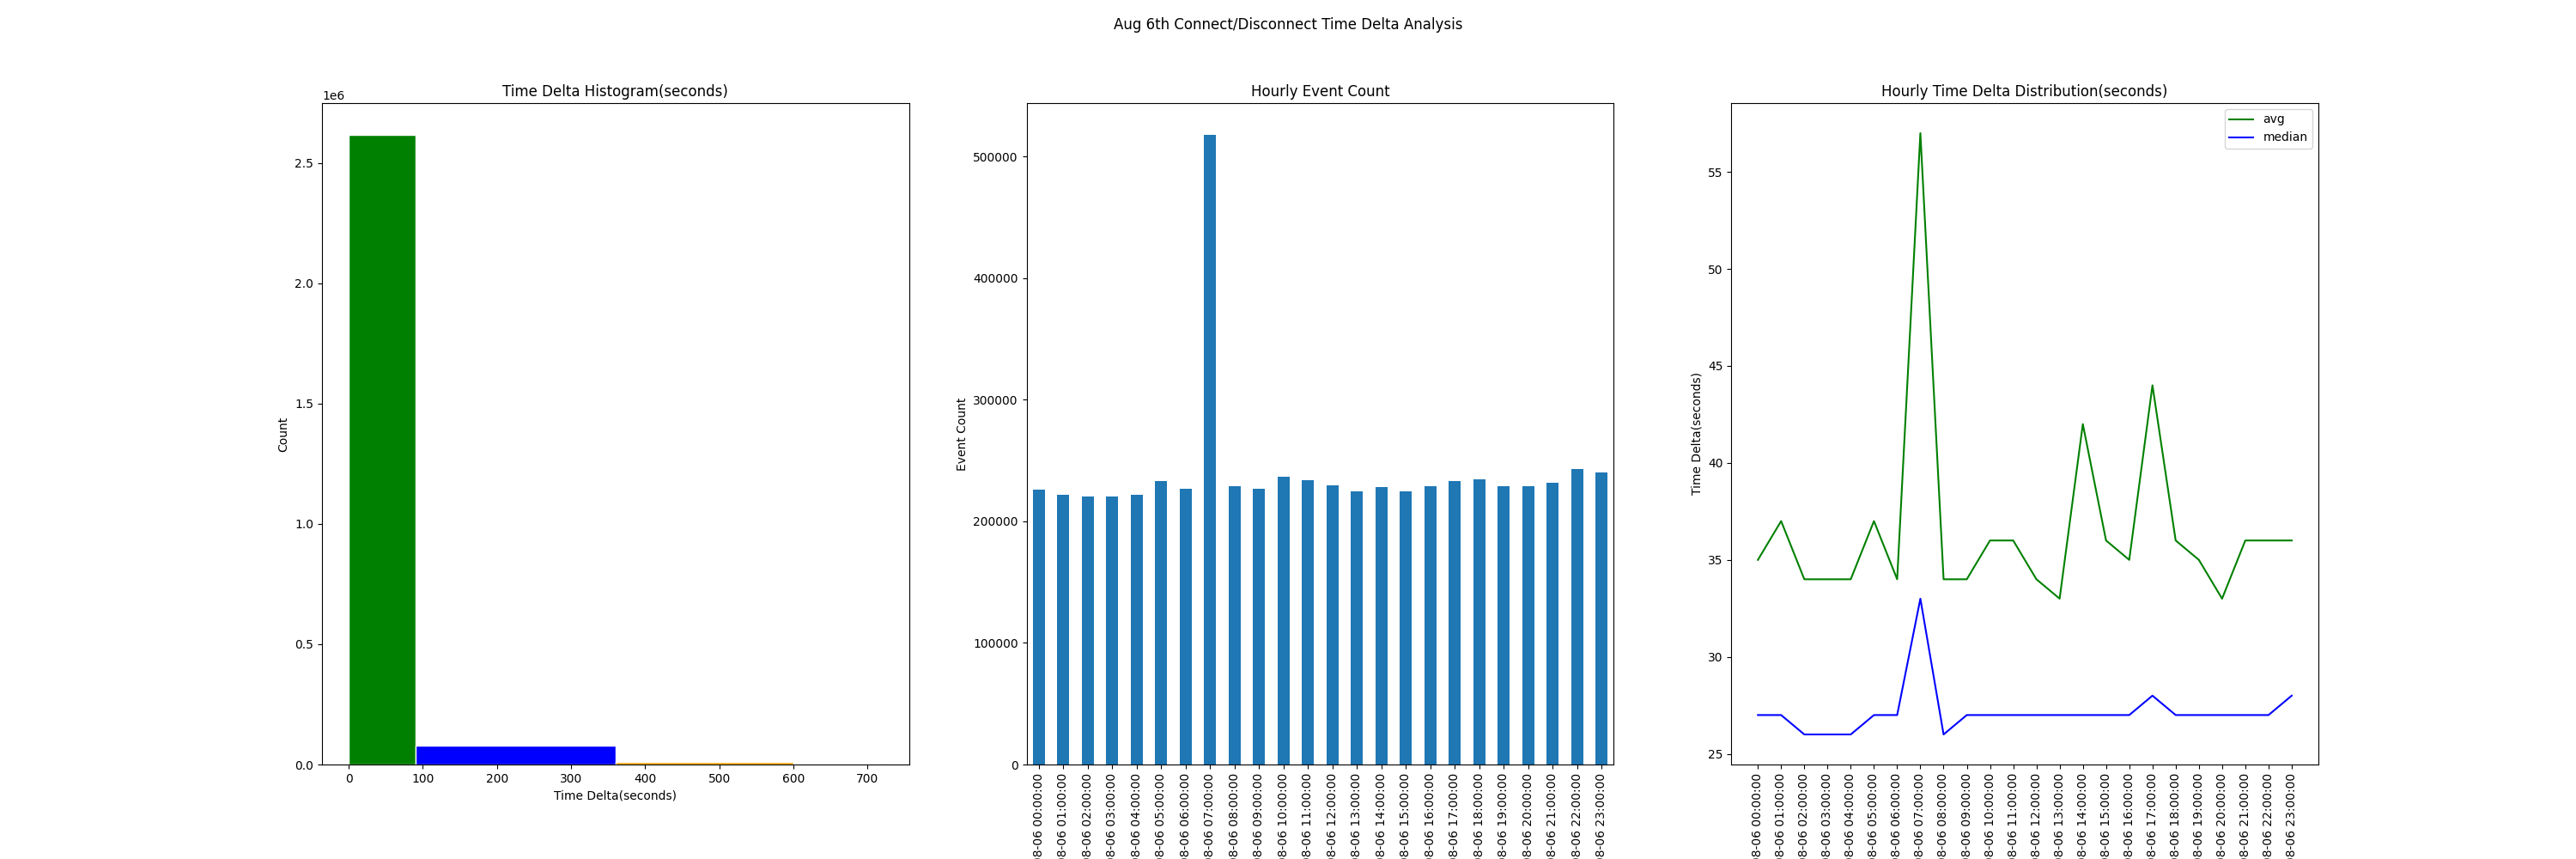

In [48]:
# Aug 06th hourly time delta
hourly_pdf, delta_pdf, ad_hourly_pdf, ad_delta_pdf = agg_and_plot(6)
plot(6, hourly_pdf, delta_pdf['ts_delta'])

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

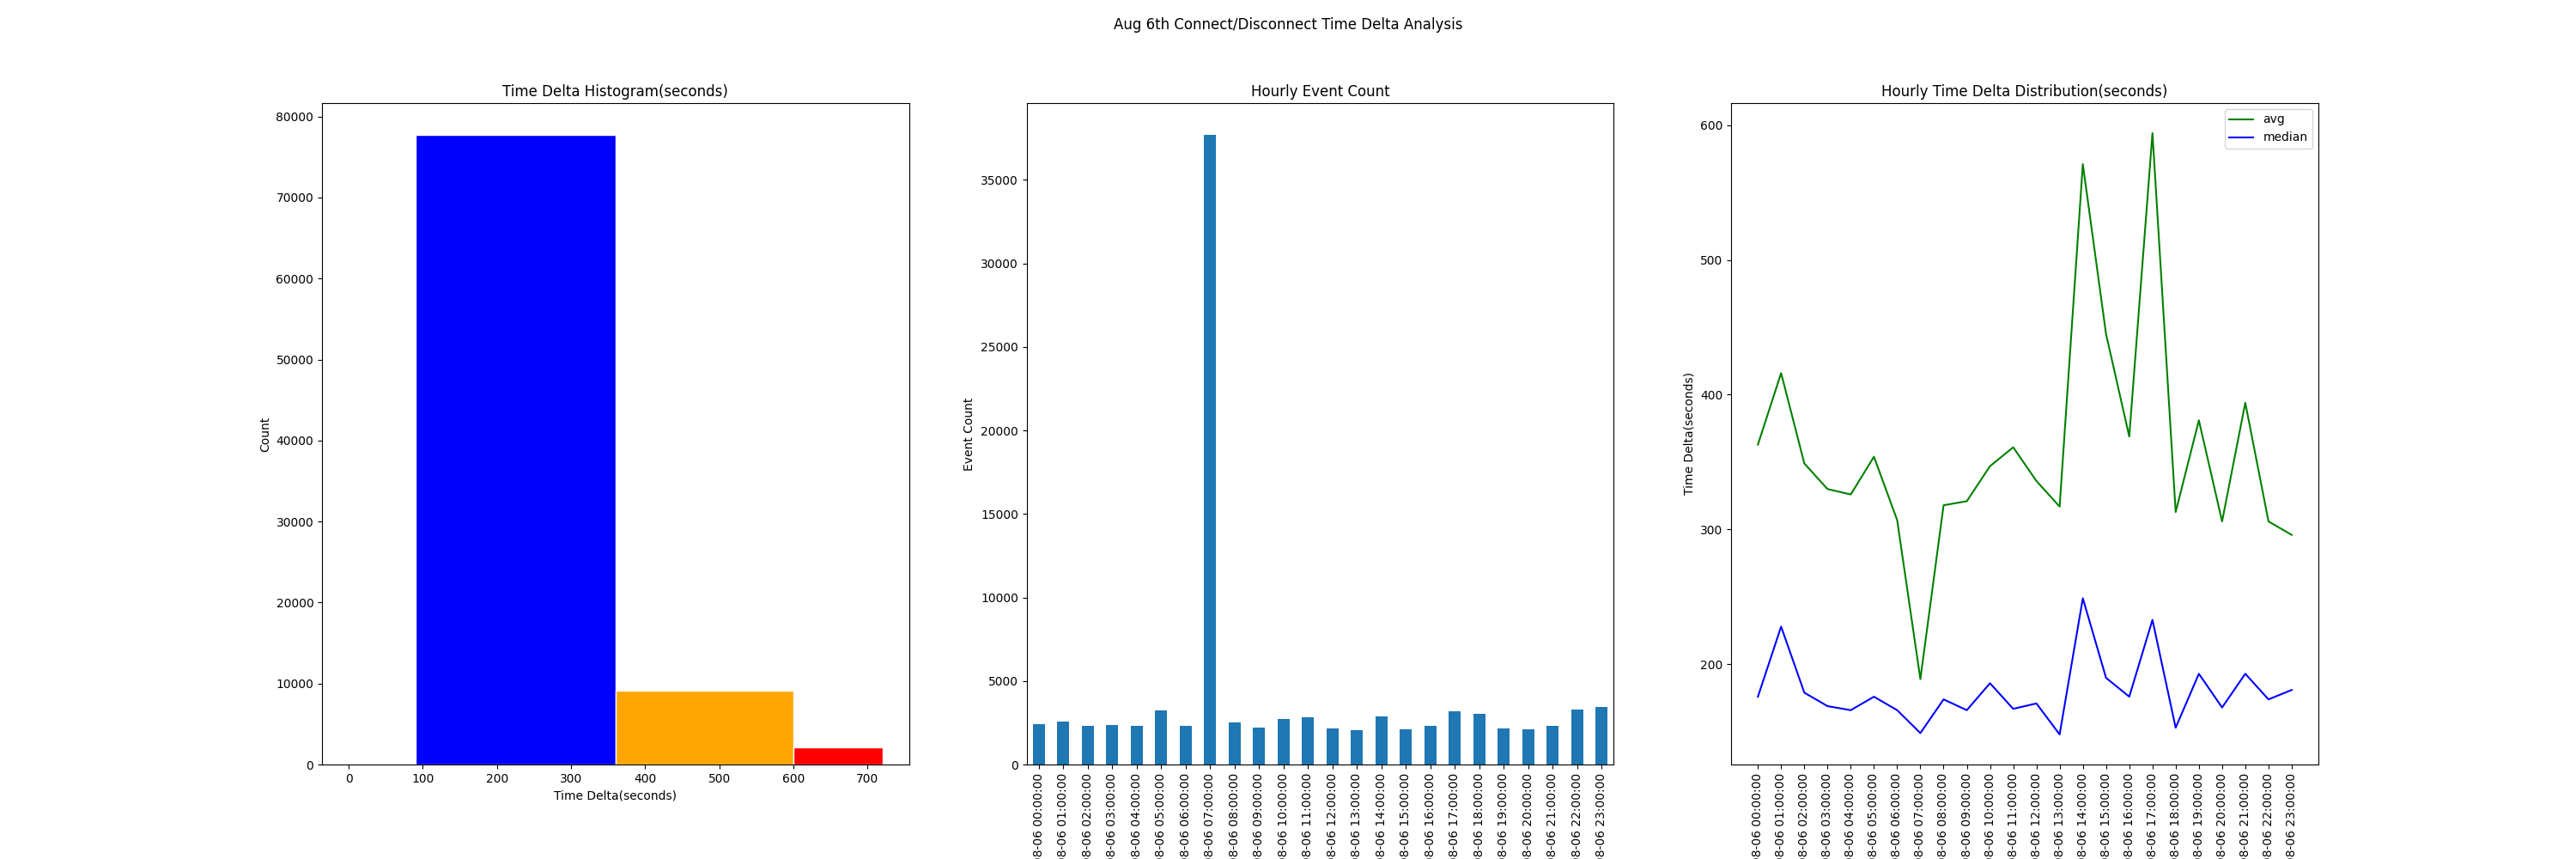

In [49]:
# Aug 06th hourly time delta exclude delta > 90
plot(6, ad_hourly_pdf, ad_delta_pdf['ts_delta'])
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

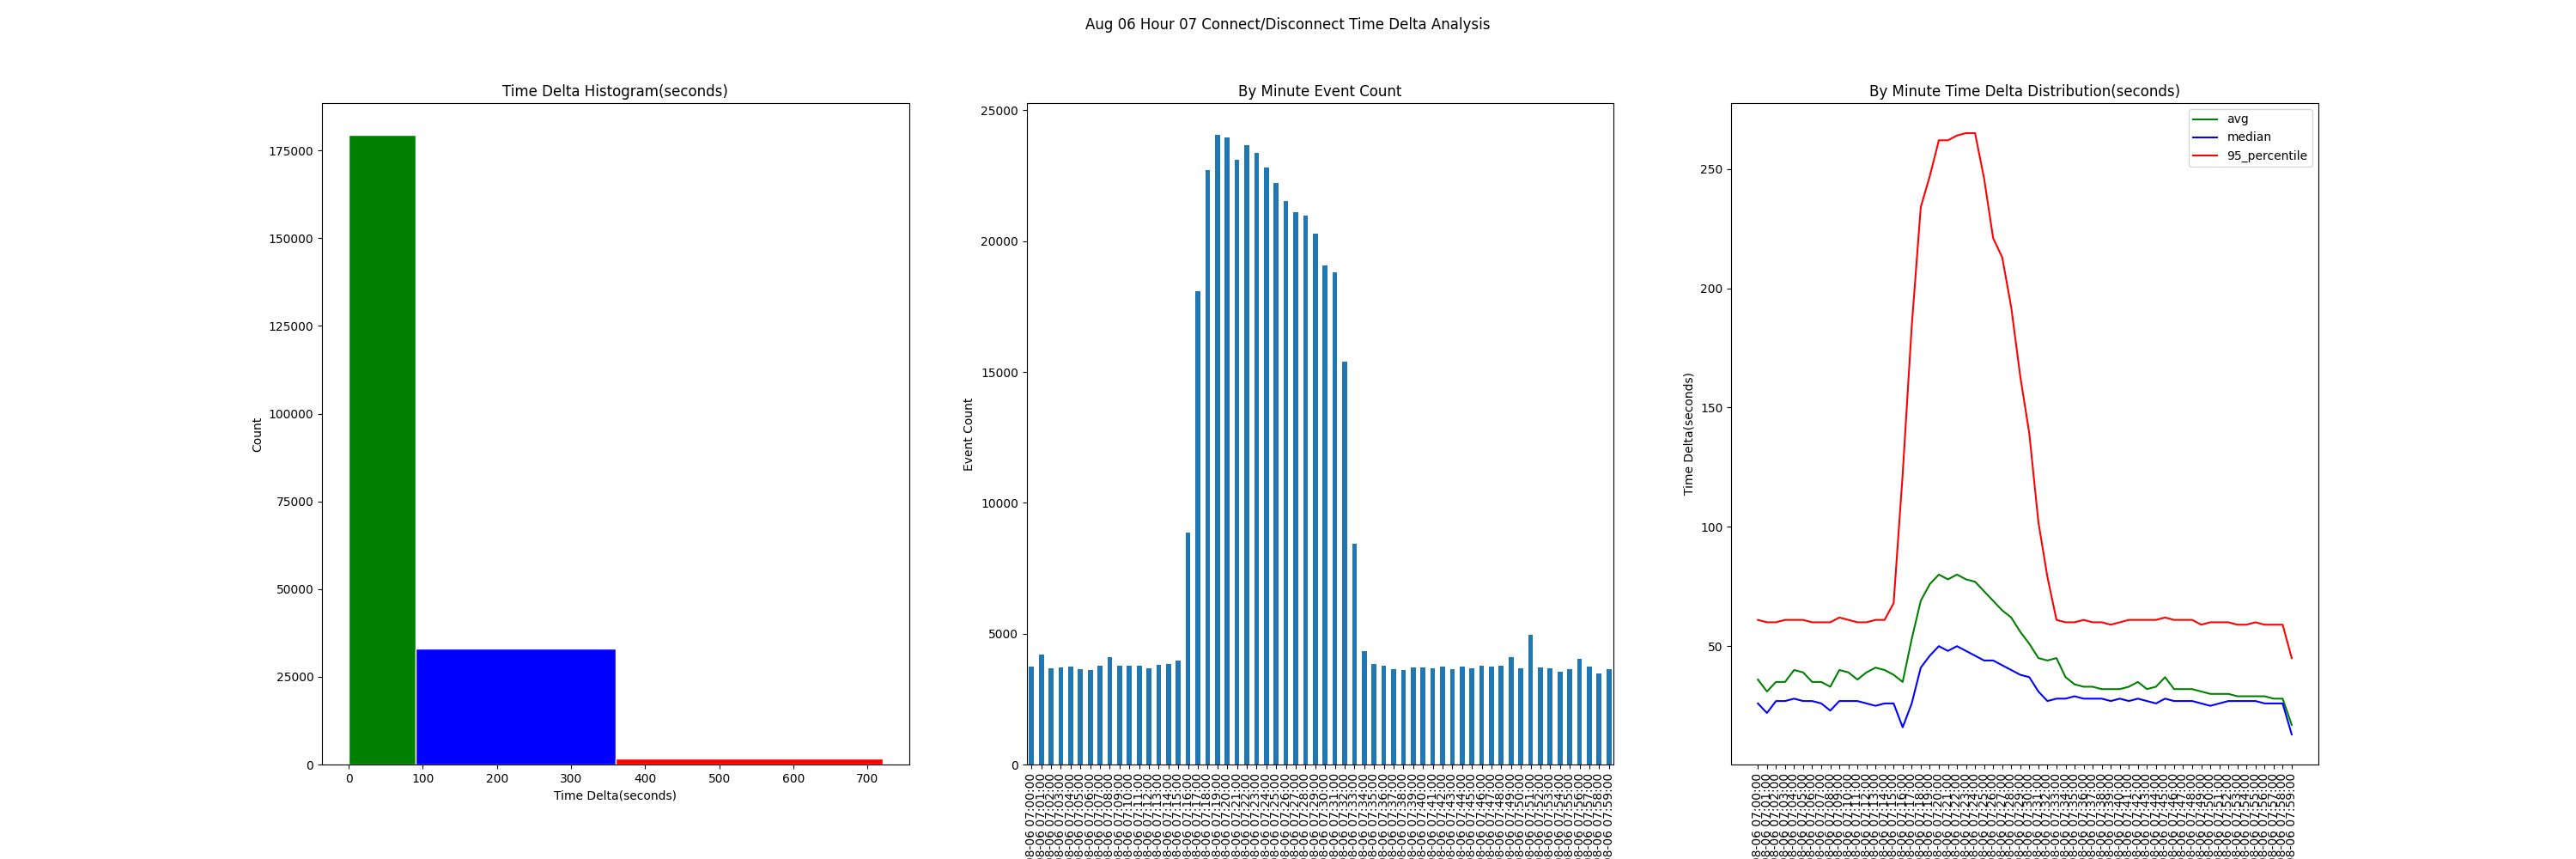

In [128]:

m_pdf1, m_pdf2, ad_m_pdf1, ad_m_pdf2 = agg_problem_hour(6, 7)
plot_hourly(6, 7, m_pdf1, m_pdf2['ts_delta'])
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

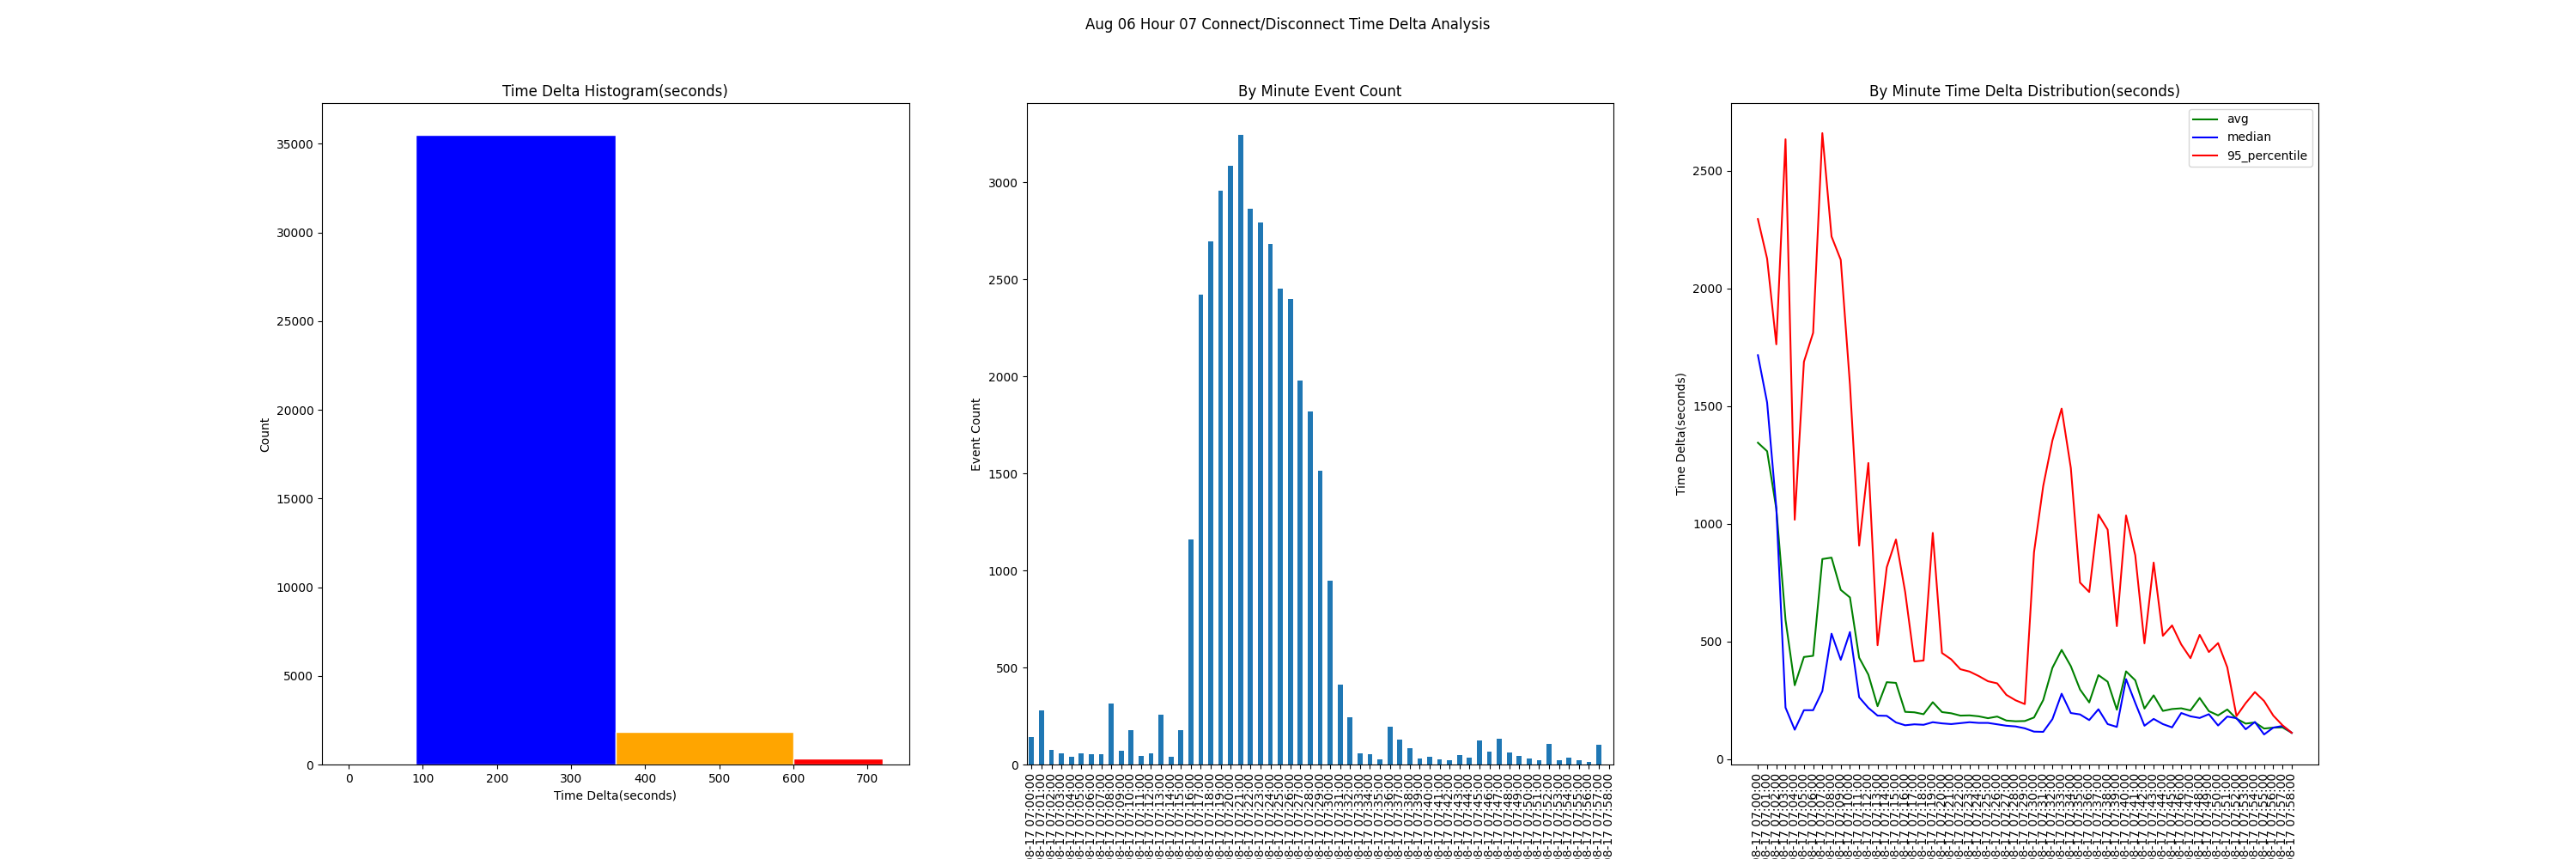

In [50]:
# exclude delta > 90s
plot_hourly(6, 7, ad_m_pdf1, ad_m_pdf2['ts_delta'])
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

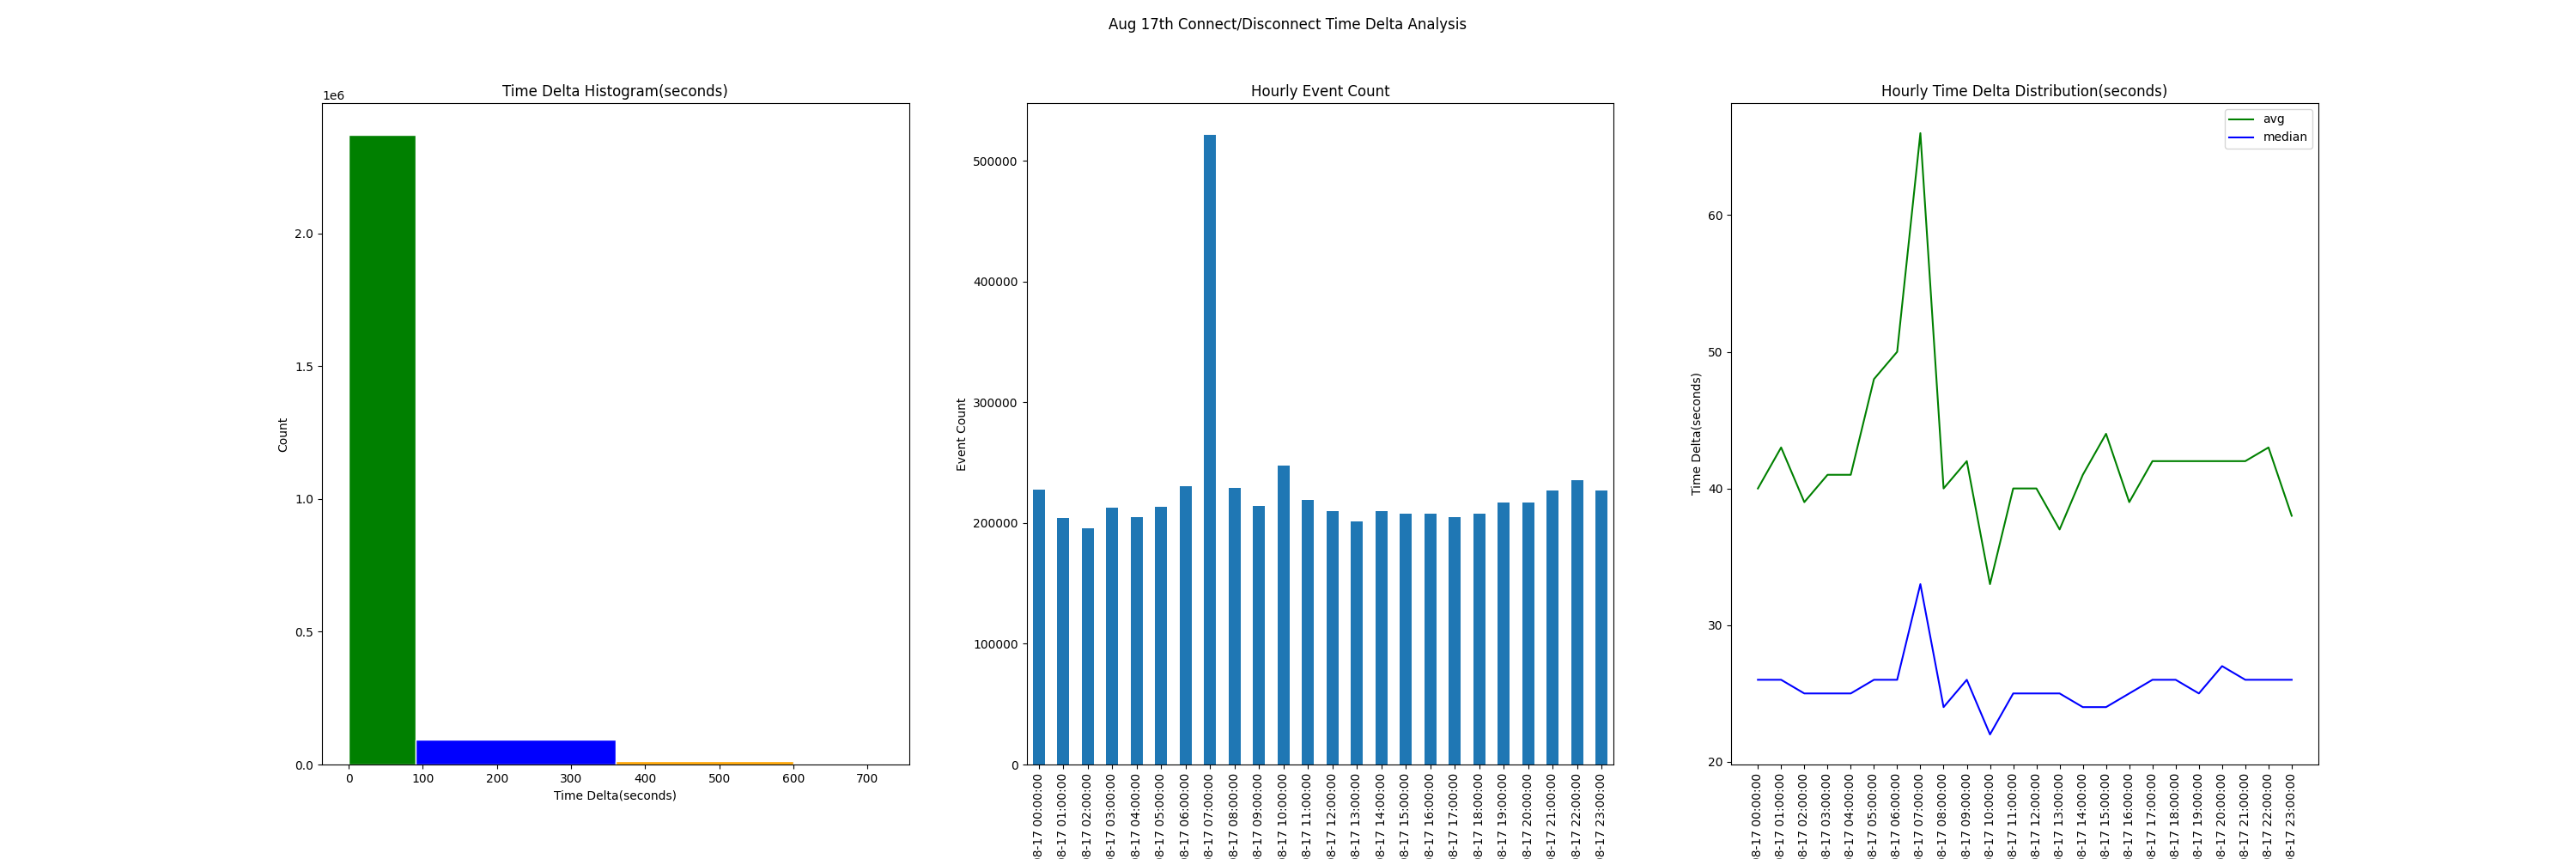

In [51]:
hourly_pdf, delta_pdf, ad_hourly_pdf, ad_delta_pdf = agg_and_plot(17)
plot(17, hourly_pdf, delta_pdf['ts_delta'])
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

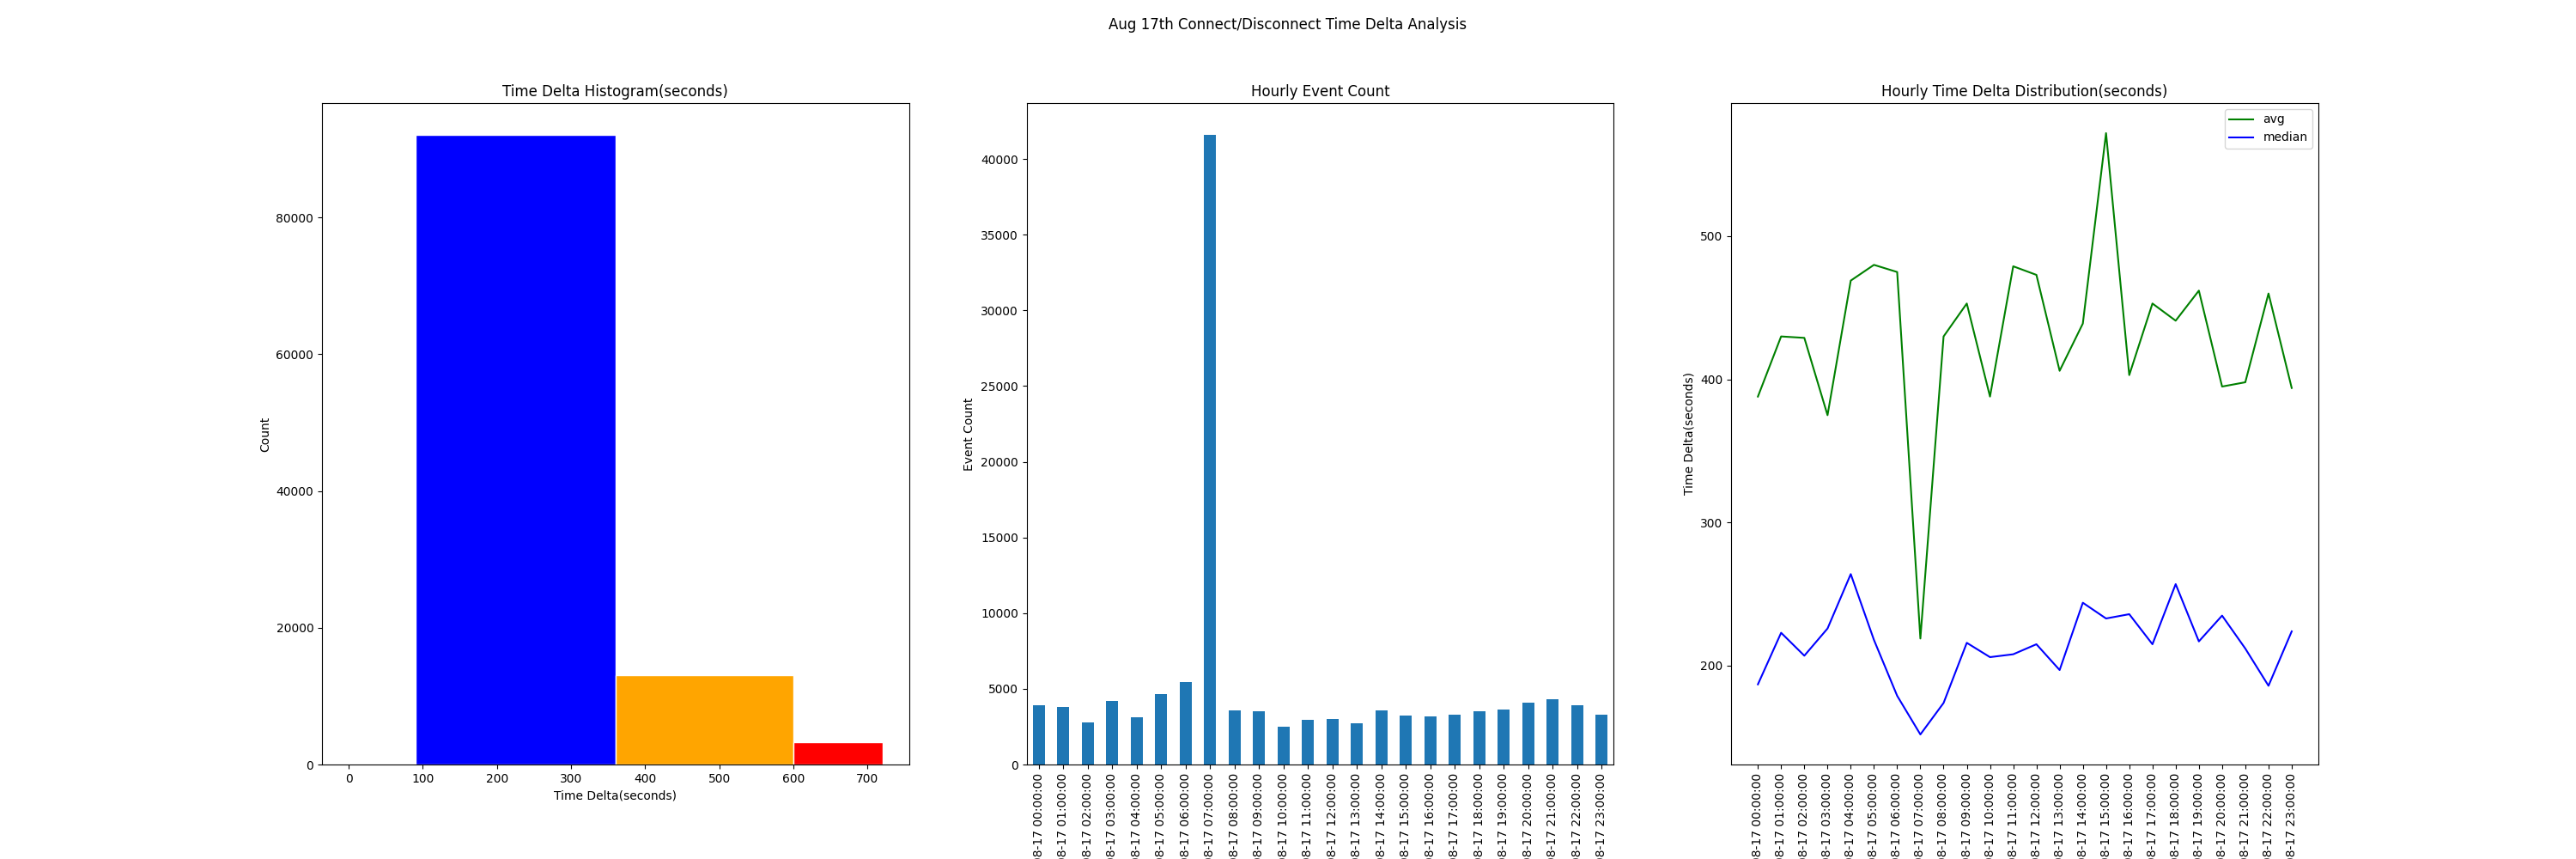

In [52]:

plot(17, ad_hourly_pdf, ad_delta_pdf['ts_delta'])
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

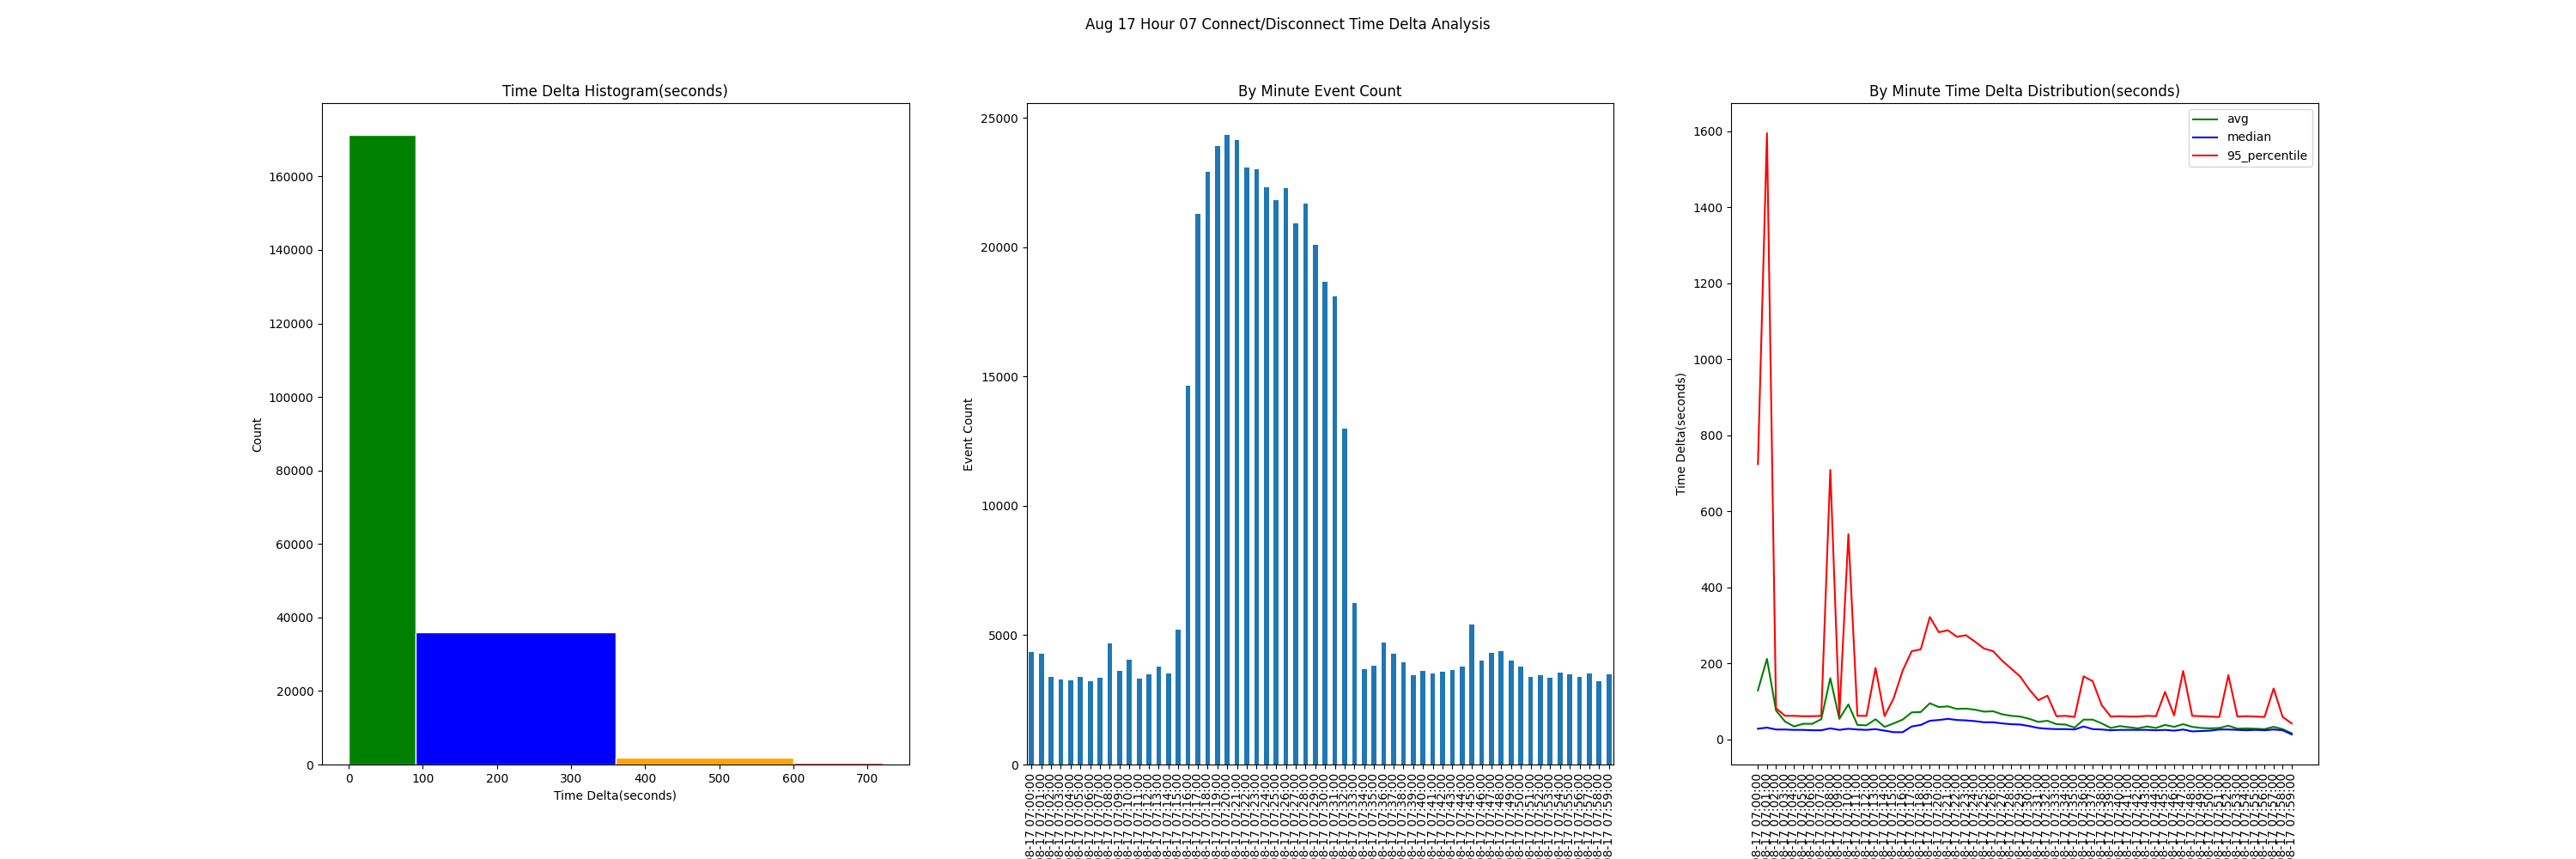

In [55]:
m_pdf1, m_pdf2, ad_m_pdf1, ad_m_pdf2  = agg_problem_hour(17, 7)
plot_hourly(17, 7, m_pdf1, m_pdf2['ts_delta'])
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

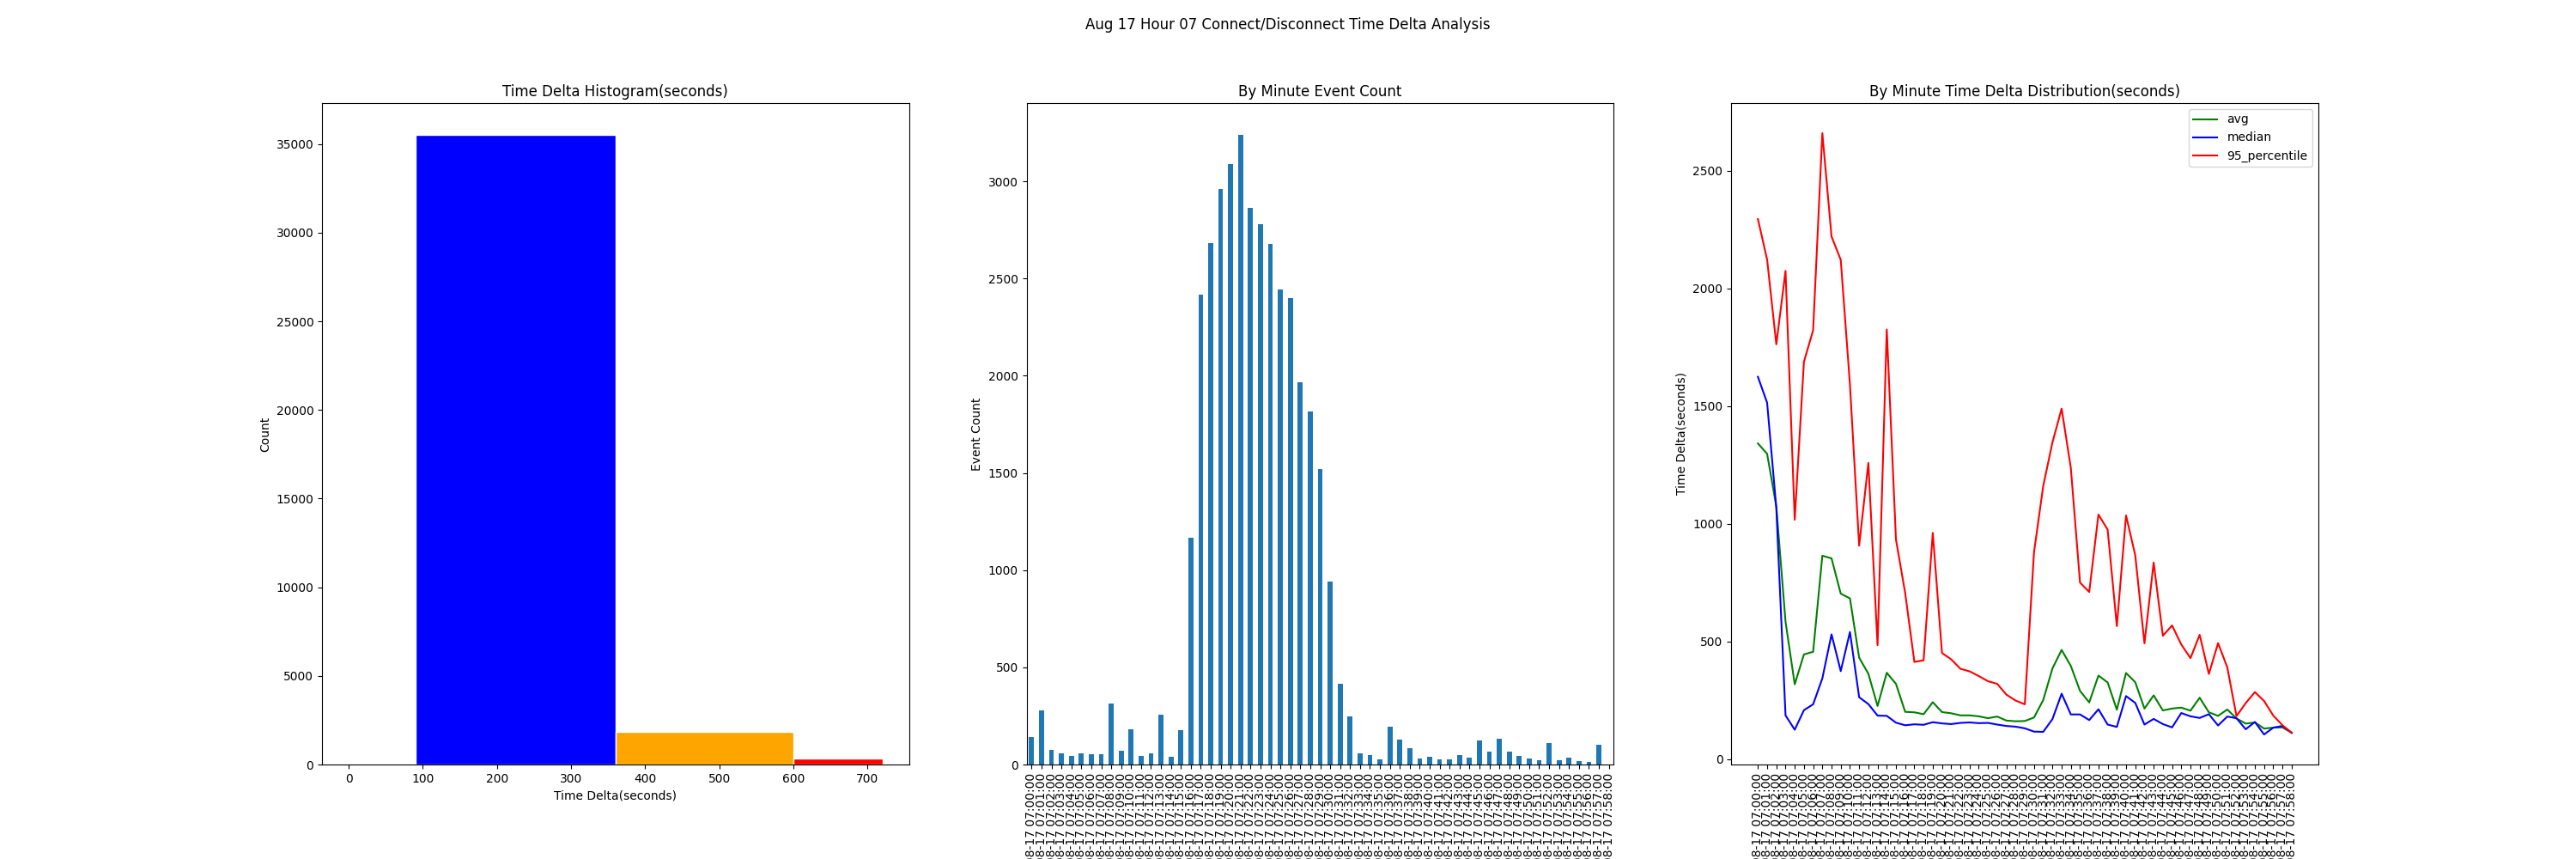

In [56]:
plot_hourly(17, 7, ad_m_pdf1, ad_m_pdf2['ts_delta'])
%matplot plt

In [ ]:
def daily_time_delta(dt_number):
    
    connet_df = spark.read.parquet('s3://mist-data-science-dev/shirley/ep-connect-status/dt=2022-08-{:02d}/hr=*/'.format(dt_number))
    formated_df = connet_df.filter( (F.col('ap').isNotNull()) & (F.length(F.col('ap')) == 17)).\
                        withColumn('ts_epoch', convert_epochUDF('timestamp')).\
                        withColumn('ts_str_1hour', convert_1hour_UDF('timestamp'))

    connect_time_delta_rdd = formated_df.rdd.groupBy(lambda r: (r['ap'], r['ts_str_1hour'])).flatMapValues(lambda r: reconnect_delta(r)).filter(lambda r: r[1] > 0).persist()
    
    
    time_delta_df = connect_time_delta_rdd.map(lambda r: Row(ap=r[0][0], ts_str_1hour=r[0][1], ts_delta=r[1])).toDF().persist()
    delta_pdf = time_delta_df.select('ts_delta').withColumn('day', F.lit('2022-08-{:02d}'.format(dt_number))).toPandas()
    
    
    return delta_pdf
    
    
    